<a href="https://colab.research.google.com/github/chayanit2022/BADS7105_CRM_Analytics/blob/main/Campaign_Response_Model_XGBoost_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [ ]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2012-01-16 00:00:00
2015-03-16 00:00:00


In [ ]:
df_transactions = df_transactions[df_transactions['trans_date']>dt.datetime(2013,1,15)]

## **Data Preparation**

In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')


df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


In [ ]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [ ]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,7,463
1,CS1113,36.0,12,872
2,CS1114,33.0,12,856
3,CS1115,12.0,12,925
4,CS1116,204.0,5,333


In [ ]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [ ]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,7,463,684,66.142857
1,CS1113,36.0,12,872,705,72.666667
2,CS1114,33.0,12,856,756,71.333333
3,CS1115,12.0,12,925,775,77.083333
4,CS1116,204.0,5,333,199,66.600000


## **Calculating response rate**

In [ ]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


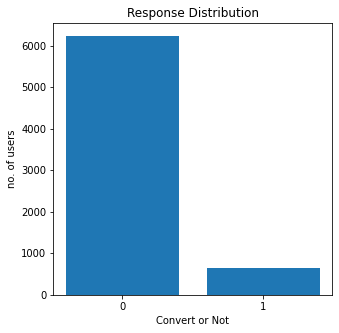

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,7,463
1,CS1113,0,36.0,12,872
2,CS1114,1,33.0,12,856
3,CS1115,1,12.0,12,925
4,CS1116,1,204.0,5,333


In [ ]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,7,463,684,66.142857
1,CS1113,0,36.0,12,872,705,72.666667
2,CS1114,1,33.0,12,856,756,71.333333
3,CS1115,1,12.0,12,925,775,77.083333
4,CS1116,1,204.0,5,333,199,66.600000


## **Creating train and test dataset**

In [ ]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [ ]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

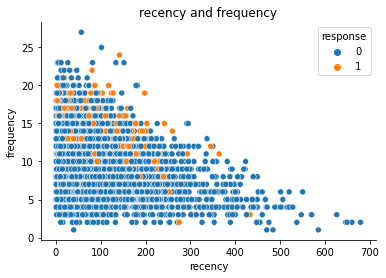

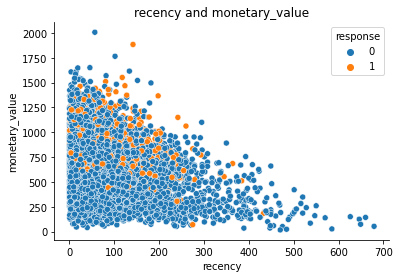

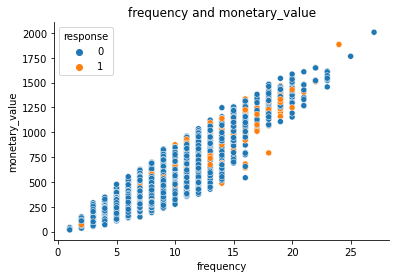

In [ ]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

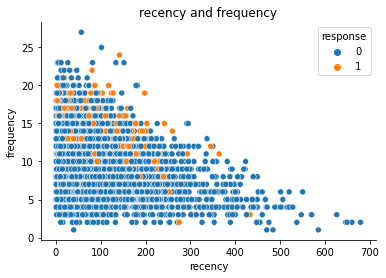

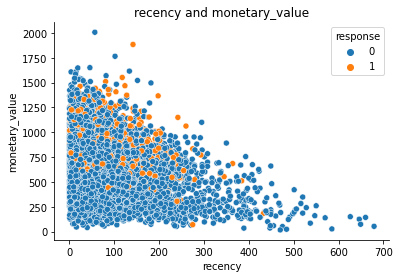

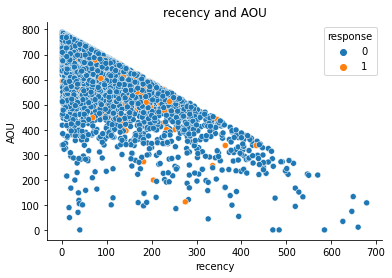

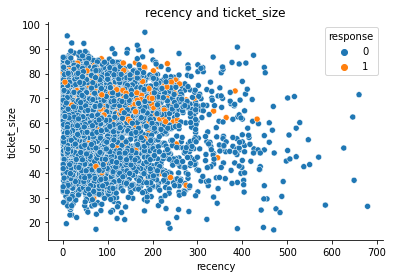

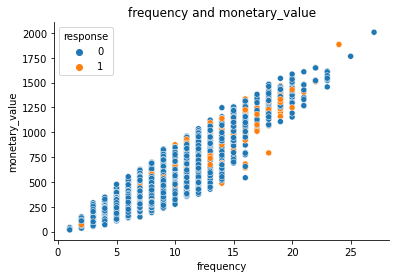

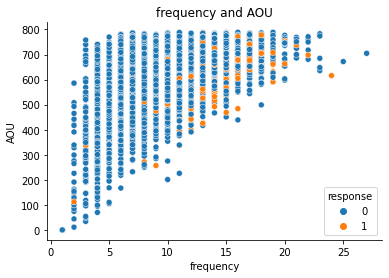

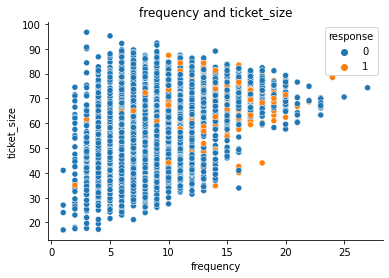

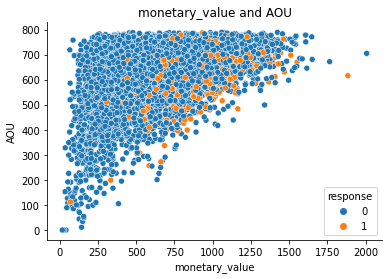

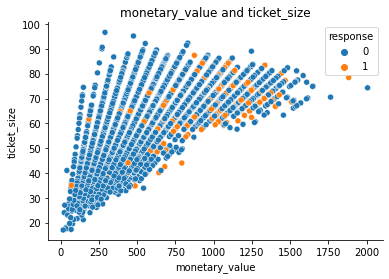

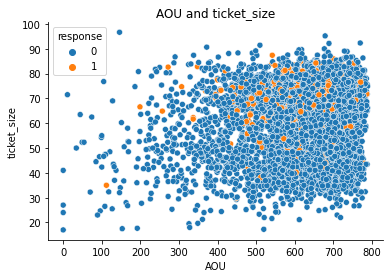

In [ ]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [ ]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      4389
           1       0.70      0.75      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.21      0.74      0.33       218

    accuracy                           0.68      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.88      0.68      0.74      2066



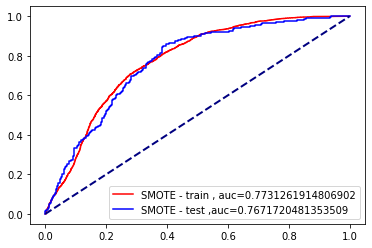

In [ ]:
y_score_train= logreg_model_SMOTE_rfm.decision_function(X_SMOTE_rfm)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm, y_score_train)
auc_train = roc_auc_score(y_SMOTE_rfm, y_score_train)
plt.plot(fpr_train,tpr_train,color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE_rfm.decision_function(X_test_rfm)
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test)
auc_test = roc_auc_score(y_test_clv,y_score_test)
plt.plot(fpr_test,tpr_test,color='Blue', label='SMOTE - test ,auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt. legend(loc=4)
plt.show()

In [ ]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      4389
           1       0.72      0.74      0.73      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1848
           1       0.21      0.69      0.32       218

    accuracy                           0.70      2066
   macro avg       0.58      0.69      0.56      2066
weighted avg       0.87      0.70      0.75      2066



## **XGBoost**

In [ ]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=250,
 max_depth=2,
 gamma=0.02,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm.to_numpy(), y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.570716
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.748435
[2]	validation_0-auc:0.746772
[3]	validation_0-auc:0.735011
[4]	validation_0-auc:0.746988
[5]	validation_0-auc:0.753427
[6]	validation_0-auc:0.747315
[7]	validation_0-auc:0.764246
[8]	validation_0-auc:0.762585
[9]	validation_0-auc:0.765492
[10]	validation_0-auc:0.761351
[11]	validation_0-auc:0.761604
[12]	validation_0-auc:0.764802
[13]	validation_0-auc:0.76539
[14]	validation_0-auc:0.765328
Stopping. Best iteration:
[9]	validation_0-auc:0.765492

training set
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      4389
           1       0.69      0.81      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

AUC Score 0.7278423331054911
test set
              precisio

In [ ]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.001,
 n_estimators=250,
 max_depth=3,
 gamma=0.02,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv.to_numpy(), y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.755669
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.765274
[2]	validation_0-auc:0.766945
[3]	validation_0-auc:0.779651
[4]	validation_0-auc:0.778793
[5]	validation_0-auc:0.773503
[6]	validation_0-auc:0.773843
[7]	validation_0-auc:0.770482
[8]	validation_0-auc:0.769152
Stopping. Best iteration:
[3]	validation_0-auc:0.779651

training set
              precision    recall  f1-score   support

           0       0.80      0.59      0.68      4389
           1       0.68      0.85      0.76      4389

    accuracy                           0.72      8778
   macro avg       0.74      0.72      0.72      8778
weighted avg       0.74      0.72      0.72      8778

AUC Score 0.723855092276145
test set
              precision    recall  f1-score   support

           0       0.97      0.59      0.74      1848
           1       0.19      0.83      0.31       218

    accuracy                           0.62

# Result


XGBoost model - SMOTE RFM

Training set
AUC Score 0.7278423331054911

Test set
AUC Score 0.7086312006036777

XGBoost model - SMOTE CLV

Training set
AUC Score 0.723855092276145

Test set
AUC Score 0.7119449739862583
